In [1]:
%matplotlib inline

import numpy as np
import collections
from collections import OrderedDict, Counter, defaultdict
import pandas as pd

import Bio
from Bio import SeqIO

import seaborn as sns
import matplotlib.pyplot as plt
from bokeh.plotting import figure, output_file, show 
import matplotlib.patches as patches    
from matplotlib import colors


import glob

import subprocess
from subprocess import call

import re

import pickle

from Bio.SubsMat import MatrixInfo
import Bio.Data.CodonTable

from scipy import stats


from Bio.SubsMat import MatrixInfo
import Bio.Data.CodonTable

import joypy

/home/alla/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# open metadata with scores and metrics
meta = pd.read_csv('tmp_res/METADATA_CURRENT.txt', sep='\t')

# gencode 25
metadata_pc_g25 = pd.read_csv('tmp_res/metadata_pc_g25.txt', sep='\t')


P_Set = pd.read_csv('tmp_res/SET1.txt', sep='\t')

R_Set = pd.read_csv('tmp_res/SET2.txt', sep='\t')

R_Set['pos_of_codon'] = [int(x.split('; ')[1].split('-')[0])-1 for x in R_Set.Riboseq_Summary.tolist()]

R_Set['codon'] = [x.split('; ')[0] for x in R_Set.Riboseq_Summary.tolist()]

R_Set[0:2]

,tr_id,gene,N_term_start1,N_term_end1,len_codons,global_coo_50_and_less,strand,global_coo_primary,PhyloCSF120score,number_of_records,ovlp,Riboseq_Summary,Coverage_value_ext,Proteomics_count_ext,tag,transcript_type,CDS_ratio,pos_of_codon,codon
0,ENST00000379389.4,ISG15,1,151,50.0,chr1:1013424-1013573,+,chr1:1013424-1013573,-2443.9971,111,0;0;0,ATC; 98-152; Rank: 288; cov: 53.85,53.846154,0.0,"basic,appris_principal_1,CCDS",protein_coding,0.327240,97,ATC
1,ENST00000349431.10,UBE2J2,28,220,64.0,chr1:1273666-1273815,-,chr1:1273666-1273857,-1285.8186,78,0;0;0,ACG; 173-221; Rank: 328; cov: 90.91,90.909091,0.0,"basic,appris_principal_1,CCDS",protein_coding,0.762814,172,ACG


In [3]:
meta[meta['gene'] == 'PEG10'].iloc[2]

tr_id                                                                          ENST00000612748.1
N_term_start                                                                                  43
N_term_end                                                                                   217
len                                                                                          174
N_term_start1                                                                                 43
N_term_end1                                                                                  217
len_codons                                                                                  58.0
gene                                                                                       PEG10
50len_flag                                                                                    67
global_coo_50_and_less                                                    chr7:94656437-94656586
strand                        

# TIS scores

## non-AUG 

In [4]:
TIS_efficiency_df = pd.read_csv('data/TIS_nonAUG_efficiency.txt', sep='\t')

TIS_efficiency_df['scaled_efficiency'] = TIS_efficiency_df['TIS Efficiency'] / TIS_efficiency_df['TIS Efficiency'].max()

TIS_efficiency_dict = dict(zip(TIS_efficiency_df['TIS Sequence'], TIS_efficiency_df['TIS Efficiency']))

TIS_efficiency_dict_scaled = dict(zip(TIS_efficiency_df['TIS Sequence'], TIS_efficiency_df['scaled_efficiency']))

TIS_efficiency_df.sort_values(by='TIS Efficiency', ascending=False).head(4)

,TIS Sequence,TIS Efficiency,scaled_efficiency
5977,CGCCCUGG,50.4,1.000000
6041,CGCGCUGG,50.4,1.000000
5913,CGCACUGG,50.4,1.000000
6001,CAUCCUGG,47.6,0.944444


## AUG 

In [5]:
TIS_AUG_eff = pd.read_csv('data/TIS_AUG_efficiency.txt', sep='\t', skiprows=1)

TIS_AUG_eff['scaled_efficiency'] = TIS_AUG_eff['efficiency'] / TIS_AUG_eff['efficiency'].max()

print (TIS_AUG_eff.efficiency.max(), TIS_AUG_eff.efficiency.min())


TIS_AUG_eff_dict = dict(zip(TIS_AUG_eff['sequence'], TIS_AUG_eff['efficiency']))


TIS_AUG_eff_dict_scaled = dict(zip(TIS_AUG_eff['sequence'], TIS_AUG_eff['scaled_efficiency']))
                           
TIS_AUG_eff[0:5]

150 12


,sequence,efficiency,lower.bound,upper.bound,scaled_efficiency
0,UUCAUCAUGCA,150,139,161,1.000000
1,GCGAGUAUGGC,149,139,161,0.993333
2,ACGAGAAUGGC,148,136,160,0.986667
3,AUCAUCAUGCA,147,136,158,0.980000
4,ACGAGUAUGGC,145,134,157,0.966667


# Load PhyloCSF scores per codon 

In [6]:
import os

li = []

path = 'data/PhyloSET_PCSF_per_codon/*/*.txt' # PhyloSET
path2 = 'data/RiboSET_PCSF_per_codon/*/*.txt' # RiboSET

for file in glob.glob(path):
    try:
        tmp = pd.read_csv(file, sep='\t', header=None)
        tmp['tr_id_codon'] = [x.split('/')[-1].split('.fasta')[0] for x in tmp[0].tolist()]
        tmp['tr_id'] = [x.split('/')[-1].split('.fasta')[0].split('_')[0] for x in tmp[0].tolist()]
        tmp['codon'] = [x.split('/')[-1].split('.fasta')[0].split('_')[1] for x in tmp[0].tolist()]
        tmp2 = tmp[['tr_id_codon', 'tr_id', 'codon', 2]]
        tmp2.columns = ['tr_id_codon', 'tr_id', 'codon', 'score']
        li.append(tmp2)
    except Exception as e:
        print (file, e)
        
        
for file in glob.glob(path2):
    try:
        tmp = pd.read_csv(file, sep='\t', header=None)
        tmp['tr_id_codon'] = [x.split('/')[-1].split('.fasta')[0] for x in tmp[0].tolist()]
        tmp['tr_id'] = [x.split('/')[-1].split('.fasta')[0].split('_')[0] for x in tmp[0].tolist()]
        tmp['codon'] = [x.split('/')[-1].split('.fasta')[0].split('_')[-1] for x in tmp[0].tolist()]
        tmp2 = tmp[['tr_id_codon', 'tr_id', 'codon', 2]]
        tmp2.columns = ['tr_id_codon', 'tr_id', 'codon', 'score']
        li.append(tmp2)
    except Exception as e:
        print (file, e)
        
RES = pd.concat(li)
RES = RES.merge(meta[['tr_id', 'gene', 'N_term_start1', 'N_term_end1', 'len_codons']]).merge(metadata_pc_g25[['tr_id', 'transcript_seq']])
RES['codon'] = RES['codon'].astype(int)
RES['score'] = RES['score'].astype(float)
print (RES.shape)
res = dict(tuple(RES.groupby('tr_id')))

data/PhyloSET_PCSF_per_codon/chr9/PhyloCSF_out.txt list index out of range
data/PhyloSET_PCSF_per_codon/chr21/PhyloCSF_out.txt list index out of range
data/PhyloSET_PCSF_per_codon/chrY/PhyloCSF_out.txt list index out of range
(52901, 9)


In [7]:
RES['tr_id'].nunique(), RES.shape # PhyloSET+RiboSET transcripts 

(468, (52901, 9))

# Plot functions 

In [8]:
def prepare_labels(tr_id, RES, primary_set, CDS):
    '''
    prepare labels as list of codons 
    '''  
    N_term_start1 = primary_set[primary_set['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1
    
    if CDS == True:
        N_term_stop1 = primary_set[primary_set['tr_id'].str.contains(tr_id)].iloc[0].N_term_end1 + 50*3 #add CDS 50 codons
    else:
        N_term_stop1 = primary_set[primary_set['tr_id'].str.contains(tr_id)].iloc[0].N_term_end1

    l = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].transcript_seq[N_term_start1:N_term_stop1]
    li = []
    for x in zip([l[i:i+3] for i in range(0, len(l), 3)], list(range(N_term_start1, N_term_stop1, 3))):
        li.append(x[0]+'_'+str(x[1]))

    return (li)
                

def prepare_data_for_PCSF_line_plot(tr_id, primary_set, RES, res, CDS):
    '''
    primary set - master df containing tons of metadat info such as tr_id,gene,
    N_term_start1,N_term_end1,len_codons,etc
    
    tr_id = transcript id
    
    RES = df containing tr_id_codon,tr_id,codon,score,gene,N_term_start1,N_term_end1,len_codons..
    '''
    
    codon_start = int(RES[RES['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1)
    
    if CDS == True:
        codon_stop = int(RES[RES['tr_id'].str.contains(tr_id)].iloc[-1].N_term_end1) + 50*3 # we add 50 codons of CDS
        len_codons = int(RES[RES['tr_id'].str.contains(tr_id)].iloc[0].len_codons) + 50 
    else:
        codon_stop = int(RES[RES['tr_id'].str.contains(tr_id)].iloc[-1].N_term_end1) 
        len_codons = int(RES[RES['tr_id'].str.contains(tr_id)].iloc[0].len_codons)
        
    ext_seq = RES[RES['tr_id'].str.contains(tr_id)].iloc[0].transcript_seq[codon_start:codon_stop]
    ext_seq_codons = [ext_seq[i:i+3] for i in range(0, len(ext_seq), 3)]
    
    # positions of different start codons
    CTG = list(np.where(np.array(ext_seq_codons) == 'CTG')[0]) # green
    ATG = list(np.where(np.array(ext_seq_codons) == 'ATG')[0]) # cyan
    GTG = list(np.where(np.array(ext_seq_codons) == 'GTG')[0]) # cyan
    TTG = list(np.where(np.array(ext_seq_codons) == 'TTG')[0]) # cyan
    ATA = list(np.where(np.array(ext_seq_codons) == 'ATA')[0]) # black
    ATT = list(np.where(np.array(ext_seq_codons) == 'ATT')[0]) # black
    ACG = list(np.where(np.array(ext_seq_codons) == 'ACG')[0]) # black 
    ATC = list(np.where(np.array(ext_seq_codons) == 'ATC')[0]) # black
    AAG = list(np.where(np.array(ext_seq_codons) == 'AAG')[0]) # black 
    AGG = list(np.where(np.array(ext_seq_codons) == 'AGG')[0]) # black
    XTG_pos = CTG + GTG + TTG
    rest = ATA + ATT + ACG + ATC + AAG + AGG
    
    # labels: codon + position 
    labels = prepare_labels(tr_id=tr_id, RES=RES, primary_set=primary_set, CDS=CDS)
    
    d = {'labels':labels, 
        'codon_start': codon_start, 
        'codon_stop': codon_stop, 
         'len_codons': len_codons, 
         'ext_seq': ext_seq, 
         'ext_seq_codons': ext_seq_codons,
         'res': res, 
          'RES':RES,
         'XTG_pos':XTG_pos,
        'ATG': ATG, 
        'rest':rest, 
        'tr_id':tr_id}
         
         
    return d


codon_dict = Bio.Data.CodonTable.standard_dna_table.forward_table # {'TTT': 'F','TTC': 'F', 'TTA': 'L'
blosum62_dict = MatrixInfo.blosum62  # ('Z', 'Y'): -2,

def output_matrix_for_plotting(fasta_input):
    # open fasta, save triplets 
    aln = []
    with open(fasta_input, 'r') as input_handle:
        for record in SeqIO.parse(input_handle, "fasta"):
            seq = str(record.seq)
            aln.append([seq[i:i+3] for i in range(0, len(seq), 3)]) 
            
    # transform triplets into aa
    aa_matrix = []

    for pos in range(0, len(aln[0])): # len(aln[0]) = number of triplets 
        
        aa_col = []
        triplet_column = [x[pos] for x in aln]
        
        ref_codon = triplet_column[0]
    
        for codon in triplet_column: 
            # codon -> aa 
            if (codon.find('-') != -1):
                aa = '-'
                codon_ = '-'
            elif (codon.find('.') != -1):
                aa = '.'
                codon_ = '.'
            elif (codon.find('N') != -1):
                aa = 'N'
                codon_ = 'N'
            elif (codon == 'TAG') | (codon == 'TGA') | (codon == 'TAA'):
                aa = 'STOP'
                codon_ = 'STOP'
            else:
                aa = codon_dict[codon]
                codon_ = codon
        
            aa_col.append('%s_%s' % (aa, codon_))
        aa_matrix.append(aa_col)
        
    aa_matrix = np.array(aa_matrix).T
            
    # color and number matrices
    final_out = []
    final_out_v = []

    for pos in range(0, len(aa_matrix[0])): # len(aln[0]) = number of triplets 
        final_col = []
        final_col_v = []

        aa_column = [x[pos] for x in aa_matrix]
        ref_aa = aa_column[0].split('_')[0]
        ref_codon = aa_column[0].split('_')[1]
    
        if ref_codon == 'ATG':
            final_col.append('blue')
            final_col_v.append(20)
        else:
            final_col.append('white')
            final_col_v.append(1)

        for aa in aa_column[1:]:
            aa_letter = aa.split('_')[0]
            codon = aa.split('_')[1]
        
        
            if aa_letter == 'ATG':
                print (aa_letter, codon, pos)
        
            # compare aa and compare codons
        
            if codon == ref_codon:    # white=1, darkgreen=5, grey=10, purple=15, blue=20, lightgreen=25, red=30
                if codon == 'ATG':
                    color = 'blue'
                    number = 20
                else:
                    color = 'white'
                    number = 1
            
            elif codon != ref_codon:
                if aa_letter == ref_aa: # conservative
                    color = 'darkgreen'
                    number = 5
                else: 
                    if (aa_letter == '-') | (aa_letter == '.') | (aa_letter == 'N'):
                        color = 'grey'
                        number = 10
                    elif (aa_letter == 'STOP'):
                        color = 'purple'
                        number = 15
                    elif (codon == 'ATG'):
                        color = 'blue'
                        number = 20
                    else:
                        try:
                            score = blosum62_dict[(ref_aa, aa_letter)]
                        except:
                            score = blosum62_dict[(aa_letter, ref_aa)]
                        if score > 0: # synonimous 
                            color = 'lightgreen'
                            number = 25
                        else:
                            color = 'red' # radical
                            number = 30
   
            final_col.append(color)
            final_col_v.append(number)

        final_out.append(final_col)
        final_out_v.append(final_col_v)
    
    final_out = np.array(final_out).T
    final_out_v = np.array(final_out_v).T
    
    return (final_out_v[::-1])



def plot_PCSF_score_and_aln_trips(d,  matrix, figsize=(22, 5), X=45, Y=55, add_point=False):
    
    tr_id = d['tr_id']
    fig, ax = plt.subplots(3, 1, figsize=figsize, sharex = True,
                           gridspec_kw={'height_ratios': [10, 5, 1], 
                                       'wspace':0.05, 'hspace':0.05}) 
    
    aln_ax = ax[0]
    line_plot_ax = ax[1]
    codon_ax = ax[2]
    #trips_ax = ax[3]
    
    cmap = colors.ListedColormap(['white', 'limegreen', 'grey', 'purple', 'deepskyblue', 'springgreen', 'red'])
    bounds=[0,  1, 5, 10, 15, 20, 25, 30, 35]
    norm = colors.BoundaryNorm(bounds, cmap.N) 
    aln_ax.imshow(matrix, interpolation='nearest', origin='lower',cmap=cmap, norm=norm, aspect='auto')
    aln_ax.set_xticks(range(0, d['len_codons']))
    aln_ax.set_xlim(0, d['len_codons'])
    aln_ax.set_yticklabels(())
    
    line_plot_ax.plot(list(range(0, len(d['res'][tr_id]['codon'].tolist()))), 
               d['res'][tr_id]['score'].tolist(), 
               c = 'grey', 
               linewidth=7)
    line_plot_ax.set_xlim(0, d['len_codons'])
    line_plot_ax.axhline(y=0, color='r', linestyle='-', linewidth=7)
    #line_plot_ax.set_ylabel('PhyloCSF_score', fontsize=X)
    #line_plot_ax.set_xlabel('Codon number', fontsize=X)

    line_plot_ax.tick_params(axis='y', labelsize=45)
    #line_plot_ax.set_title(d['RES'][d['RES']['tr_id'] == tr_id].iloc[0].gene+'_'+tr_id, fontdict={'fontsize': X})
    line_plot_ax.set_xticks(range(0, d['len_codons']))
    line_plot_ax.set_yticklabels(())
    line_plot_ax.set_xlim(0, d['len_codons'])
    
    if add_point is not False:
            # add point position: right from the start of primary extension 
            # we have to add it manually 
            # it's a position of codon starting from the start of primary extension 
            x1 = add_point
            y1 = res[tr_id]['score'].tolist()[x1]
            line_plot_ax.scatter(x1, y1, s=1800, c='blue', marker='o', label='Ribo-seq')

    for codon_pos in d['XTG_pos']:
        codon_ax.axvline(x=codon_pos, c='dodgerblue', linewidth=7)
        
    for codon_pos in d['ATG']:
        codon_ax.axvline(x=codon_pos, c='violet', linewidth=7)
        
    for codon_pos in d['rest']:
        codon_ax.axvline(x=codon_pos, c='darkred', linewidth=7)
        
    codon_ax.xaxis.label.set_visible(False)
    codon_ax.yaxis.label.set_visible(False)
    codon_ax.set_yticklabels([])
    codon_ax.set_facecolor('whitesmoke')
    
    
    codon_ax.set_xticks(list(range(0, d['len_codons'])))
    codon_ax.set_xticklabels(labels=d['labels'], fontdict={'fontsize': Y})
    
    for tick in codon_ax.get_xticklabels():
        tick.set_rotation(90)
        
    # # # # # # # TRIPS # # # # # # #
    
    
    

    # # # # # # # TRIPS # # # # # # # #
        
    # align axis 
    pos = aln_ax.get_position()
    pos2 = line_plot_ax.get_position()
    line_plot_ax.set_position([pos.x0, pos2.y0, pos.width, pos2.height])

    pos3 = line_plot_ax.get_position()
    pos4 = codon_ax.get_position()
    codon_ax.set_position([pos3.x0, pos4.y0, pos3.width, pos4.height])
    
    #pos5 = codon_ax.get_position()
    #pos6 = trips_ax.get_position()
    #trip
    #s_ax.set_position([pos5.x0, pos6.y0, pos5.width, pos6.height])
    
    plt.show()
    
    
    
def prepare_data_for_trips2(meta, file_counts, metadata_pc_g25, 
                           tr_id, gene, l, p, fraq, cds, 
                           predicted_ext_start=False, figsize=(20, 10),
                           xlims='full', zeros=True):
    
    f = pd.read_csv(file_counts)
    f.columns = ['Position', 'Sequence', 'Frame1', 'Frame2', 'Frame3', 'RNASeq']
    
    atgs_pos = {'frame_0':[], 'frame_1':[], 'frame_2':[]}
    stop_pos = {'frame_0':[], 'frame_1':[], 'frame_2':[]}

    for pos in f.Position.tolist():
        codon = ''.join(f.Sequence.tolist()[(pos-1):(pos-1+3)])
        if codon == 'ATG':
            if pos % 3 == 0:
                atgs_pos['frame_0'].append(pos)
            elif pos % 3 == 1:
                atgs_pos['frame_1'].append(pos)
            else:
                atgs_pos['frame_2'].append(pos)
            
        elif (codon == 'TGA') | (codon == 'TAA') | (codon == 'TAG'):
            if pos % 3 == 0:
                stop_pos['frame_0'].append(pos)
            elif pos % 3 == 1:
                stop_pos['frame_1'].append(pos)
            else:
                stop_pos['frame_2'].append(pos)
        else:
            continue     
            
    # add CDS borders
    cds_stop_pos = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_stop_pos
    cds_start_pos = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos + 1
    cds_start_codon = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_codon
    
    if xlims == 'ext':
        xlim1 = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1
        xlim2 = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].N_term_end1 + 50*3
    elif len(xlims) == 2:
        xlim1 = xlims[0]
        xlim2 = xlims[1]
    else: # full transcript
        xlim1 = 0
        xlim2 = len(metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].transcript_seq)
    
    d = {}
    
    d['cds_stop_pos'] = cds_stop_pos
    d['cds_start_pos'] = cds_start_pos
    d['cds_start_codon'] = cds_start_codon
    d['f'] = f
    d['stop_pos'] = stop_pos
    d['atgs_pos'] = atgs_pos
    d['xlims'] = (xlim1, xlim2)
    d['predicted_ext_start'] = predicted_ext_start
    d['l'] = l
    d['p'] = p
    d['figsize'] = figsize
    d['fraq'] = fraq
    d['cds'] = cds
    d['name'] = tr_id+'_'+gene
    d['zeros'] = zeros
    
    return d


def trips_full2(d):
    
    l = d['l']
    p = d['p']
    f = d['f'] # dict with frames 
    atgs_pos = d['atgs_pos']
    stop_pos = d['stop_pos']
    cds_start_pos = d['cds_start_pos']
    cds_stop_pos = d['cds_stop_pos']
    figsize = d['figsize']
    xlims = d['xlims']
    fraq = d['fraq']
    cds = d['cds']
    name = d['name']
    zeros = d['zeros']
    
    fig, axes = plt.subplots(5, 1, figsize = figsize, 
                             gridspec_kw={'height_ratios':[10,1,1,1,1]}, sharex=True, sharey=False, )

    main_plot = axes[0]
    #cds = axes[1]
    orfs = axes[1]
    red = axes[2]
    green = axes[3]
    blue = axes[4]

    # x 
    main_plot.set_xlim(f.Position.min(), f.Position.max()+1)

    # y
    
    if xlims is not False:
        f1 = f[xlims[0]:xlims[1]]
        max_height = np.max([np.max(f1.Frame1.tolist()), np.max(f1.Frame2.tolist()), np.max(f1.Frame3.tolist())])
        print (max_height)
    else:
        max_height = np.max([np.max(f.Frame1.tolist()), np.max(f.Frame2.tolist()), np.max(f.Frame3.tolist())])
        print (max_height)
        
    #### ????? why they dissappear????? ######    
    main_plot.set_ylim(0, max_height+max_height/l)
    main_plot.set_yticks(np.arange(0, max_height+max_height/l, p))
    main_plot.set_yticklabels(np.arange(0, max_height+max_height/l, p, dtype=np.int64), fontsize=35)
    
    # print (f[125:150])

    # #frame 1 = red, frame2 = green, frame3 = blue
    if zeros == True:
        main_plot.plot(f.Frame1.tolist(), color = 'coral', linewidth=9, linestyle='-')
        main_plot.plot(f.Frame2.tolist(), color = 'mediumseagreen', linewidth=9, linestyle='-')
        main_plot.plot(f.Frame3.tolist(), color = 'cornflowerblue', linewidth=9, linestyle='-')
    
    else:
        # delete zeros 
        t = f[['Position', 'Frame1']]
        fr1 = t[t['Frame1'] != 0]
        
        t = f[['Position', 'Frame2']]
        fr2 = t[t['Frame2'] != 0]
        
        t = f[['Position', 'Frame3']]
        fr3 = t[t['Frame3'] != 0]
        
        main_plot.plot(fr1.Position.tolist(), fr1.Frame1.tolist(), color = 'coral', linewidth=9, linestyle='-')
        main_plot.plot(fr2.Position.tolist(), fr2.Frame2.tolist(), color = 'mediumseagreen', linewidth=9, linestyle='-')
        main_plot.plot(fr3.Position.tolist(), fr3.Frame3.tolist(), color = 'cornflowerblue', linewidth=9, linestyle='-')
    
        
        
        
    red.set_facecolor('coral')
    green.set_facecolor('mediumseagreen')
    blue.set_facecolor('cornflowerblue')
    #cds.set_facecolor('lightgrey')

    #blue.set_xticks(np.arange(0, f.Position.max(), 50))
    #blue.set_xticklabels(np.arange(0, f.Position.max(), 50), fontsize=45)

    red.set_yticklabels(())
    green.set_yticklabels(())
    blue.set_yticklabels(())
    #cds.set_yticklabels(())
    orfs.set_yticklabels(())
    
    

    blue.set_ylabel('f2', fontsize=38)#, rotation = 0)
    red.set_ylabel('f0', fontsize=38)#, rotation = 0)
    green.set_ylabel('f1', fontsize=38)#, rotation = 0)
    #cds.set_ylabel('cds', fontsize=35)#, rotation = 0)
    orfs.set_ylabel('orf', fontsize=38)#, rotation = 0)

    for frame, pos_li in atgs_pos.items():
        if frame == 'frame_0':
            for pos in pos_li:
                blue.vlines(pos, ymin = 0, ymax = 1, colors='white', linewidth=8)
        elif frame == 'frame_1':
            for pos in pos_li:
                red.vlines(pos, ymin = 0, ymax = 1, colors='white', linewidth=8)
        else:
            for pos in pos_li:
                green.vlines(pos, ymin = 0, ymax = 1, colors='white', linewidth=8)
            
    for frame, pos_li in stop_pos.items():
        if frame == 'frame_0':
            for pos in pos_li:
                blue.vlines(pos, ymin = 0, ymax = 1, colors='black', linewidth=8)
        elif frame == 'frame_1':
            for pos in pos_li:
                red.vlines(pos, ymin = 0, ymax = 1, colors='black', linewidth=8)
        else:
            for pos in pos_li:
                green.vlines(pos, ymin = 0, ymax = 1, colors='black', linewidth=8)
            
                    
    # add start of annotated CDS
    main_plot.vlines(cds_stop_pos, ymin=0, ymax=max_height+max_height/l, colors='black', linewidth=4.5)
    main_plot.vlines(cds_start_pos, ymin=0, ymax=max_height+max_height/l, colors='black', linewidth=4.5)
    #main_plot.text(x = cds_stop_pos-100, y = max_height+max_height/10, s = 'cds stop', fontsize=39)
    #main_plot.text(x = cds_start_pos-10, y = max_height+0.1, s = 'cds start', fontsize=39)


    # add rectangle = CDS
    #if cds is True:
        #rect = patches.Rectangle((cds_start_pos, 0),cds_stop_pos-cds_start_pos,
                         #1,linewidth=1,edgecolor='r',facecolor='lightgrey')
        #cds.add_patch(rect)

        # add non-AUG - cds_start_pos
        #cds.text(x = cds_start_pos, y = 0.3, s = 'AUG', fontsize=38)

    
    # add rectangle = extended CDS
    xlims = d['xlims']
    predicted_ext_start = d['predicted_ext_start']
    if xlims is not False:
        if predicted_ext_start is not False:
            Nst = int(predicted_ext_start.split('_')[0])
            codon_name = predicted_ext_start.split('_')[1]
            N2 = cds_stop_pos
            rect = patches.Rectangle((Nst, 0), N2-Nst,1,linewidth=1,edgecolor='r',facecolor='silver')
            orfs.add_patch(rect)
        
            orfs.text(x = Nst, y = 0.3, s = codon_name, fontsize=38)

    
    blue.set_xticks(range(f.Position.min(), f.Position.max()+1, fraq))       
    blue.set_xticklabels(range(f.Position.min(), f.Position.max()+1, fraq), fontsize=38)
    
    print (f.Position.min())
    
    
    if xlims is not False:    
        plt.xlim(xlims[0], xlims[1])
        
        
    main_plot.set_title(name, fontsize=45)
    plt.subplots_adjust(left=0.1, bottom=0.1,
                    wspace=0.1, hspace=0.1)
    

# Test Plots 

146
0


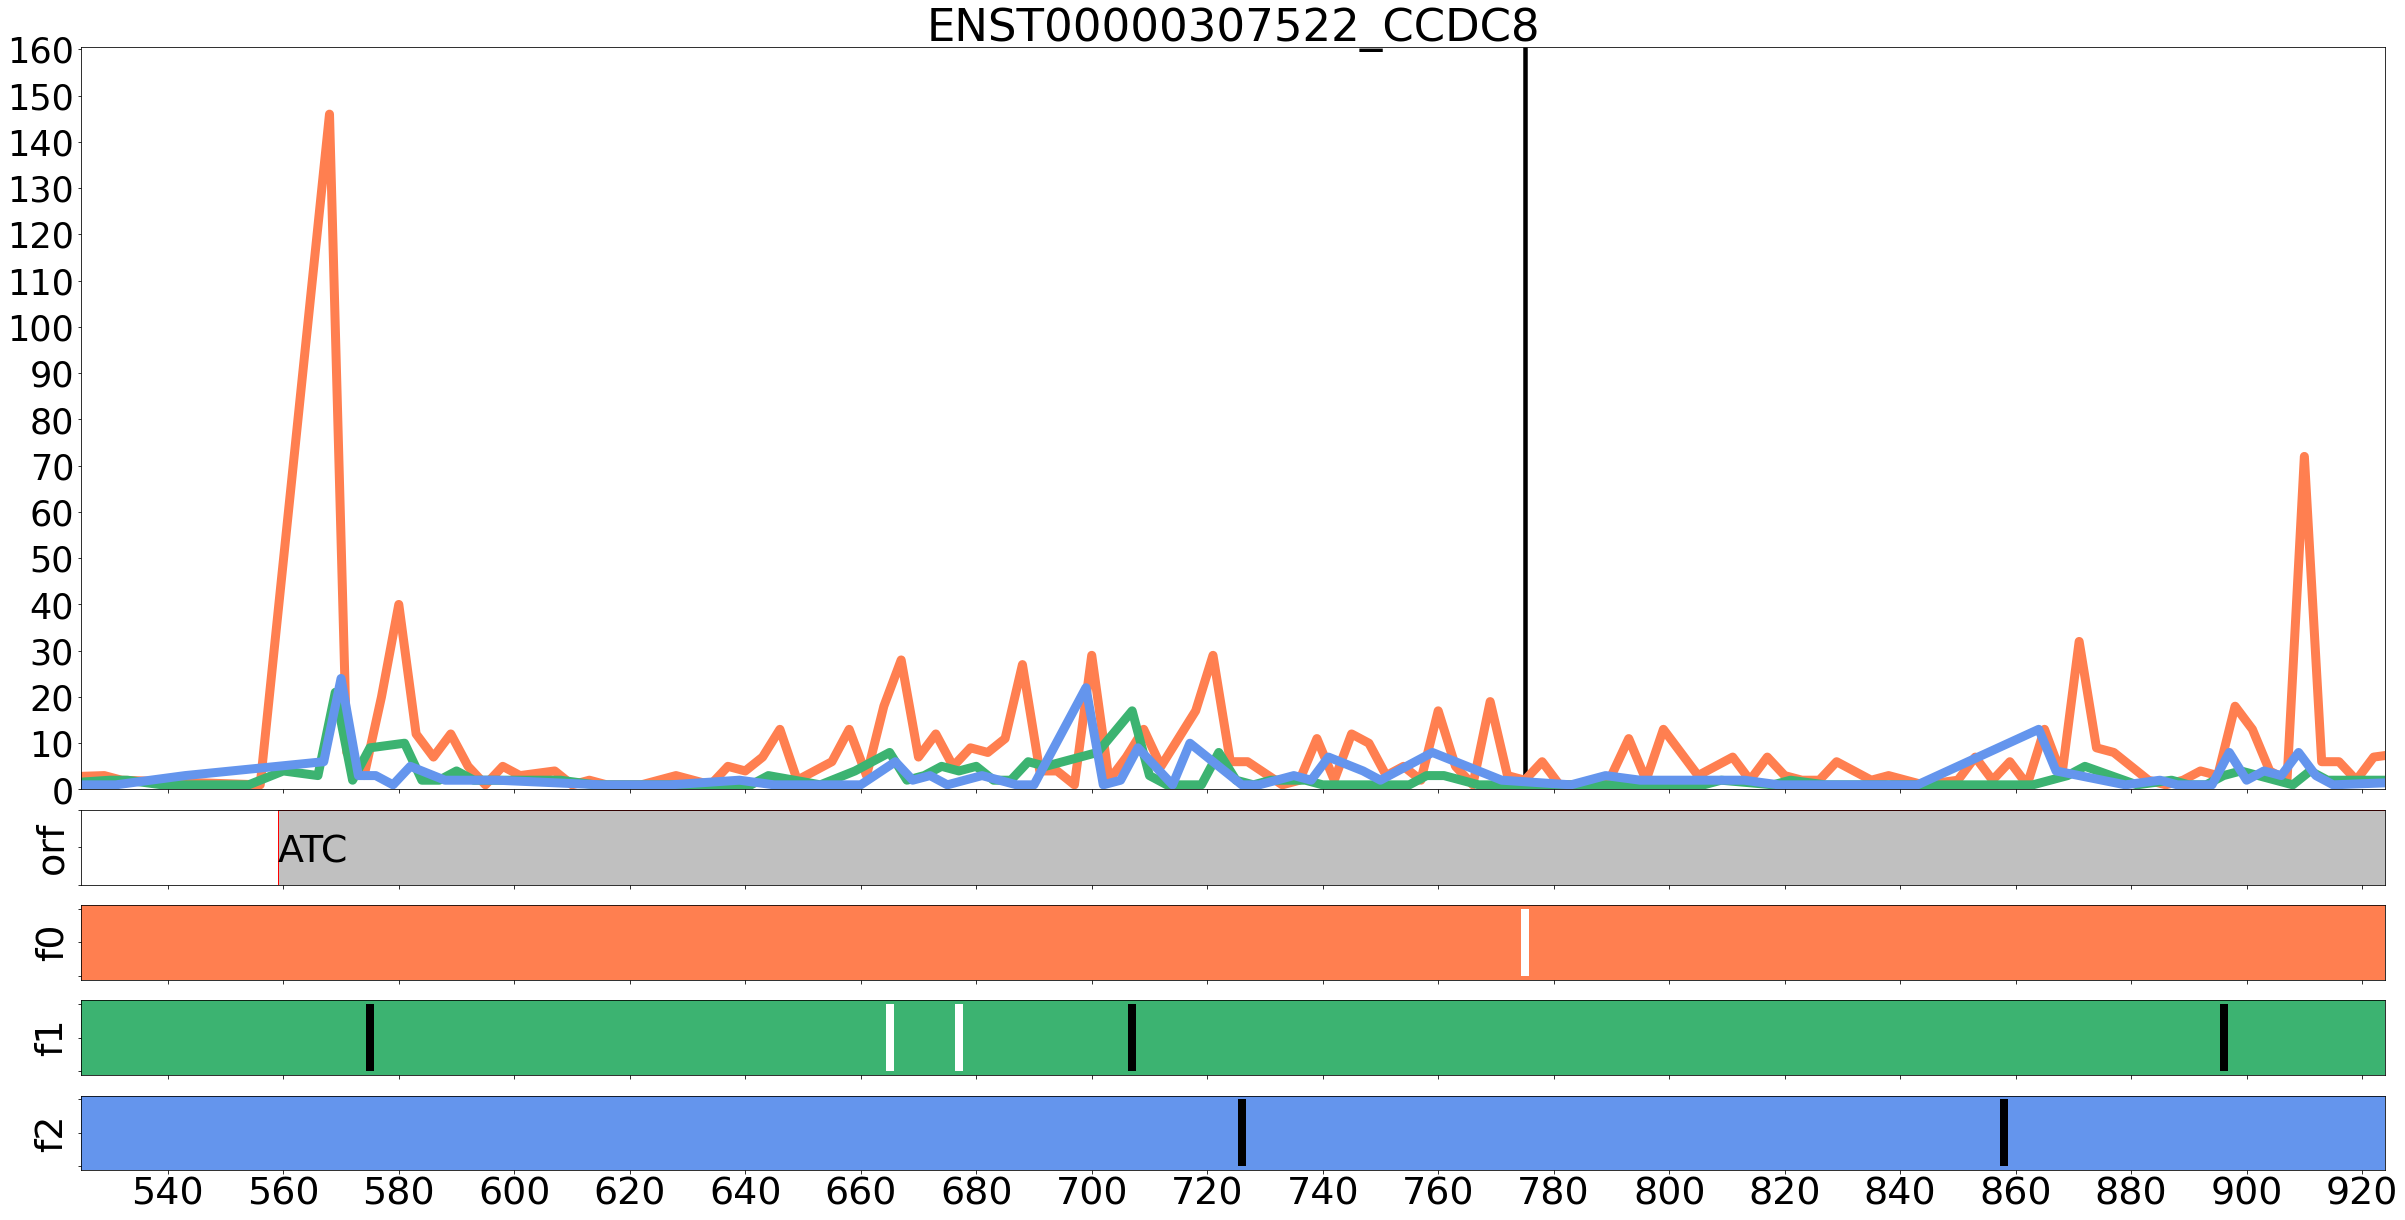

In [9]:
gene = 'CCDC8'

tr_id = 'ENST00000307522'


pred_start = R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split(';')[0]
pos_pred_start = R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0] 


pre_st = pos_pred_start + '_' + pred_start

xlims = [R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*3]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_RiboSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =10, 
                             fraq = 20, 
                             cds = False,
                           figsize=(40, 20),
                           xlims=xlims,
                            zeros=False)

trips_full2(d1)

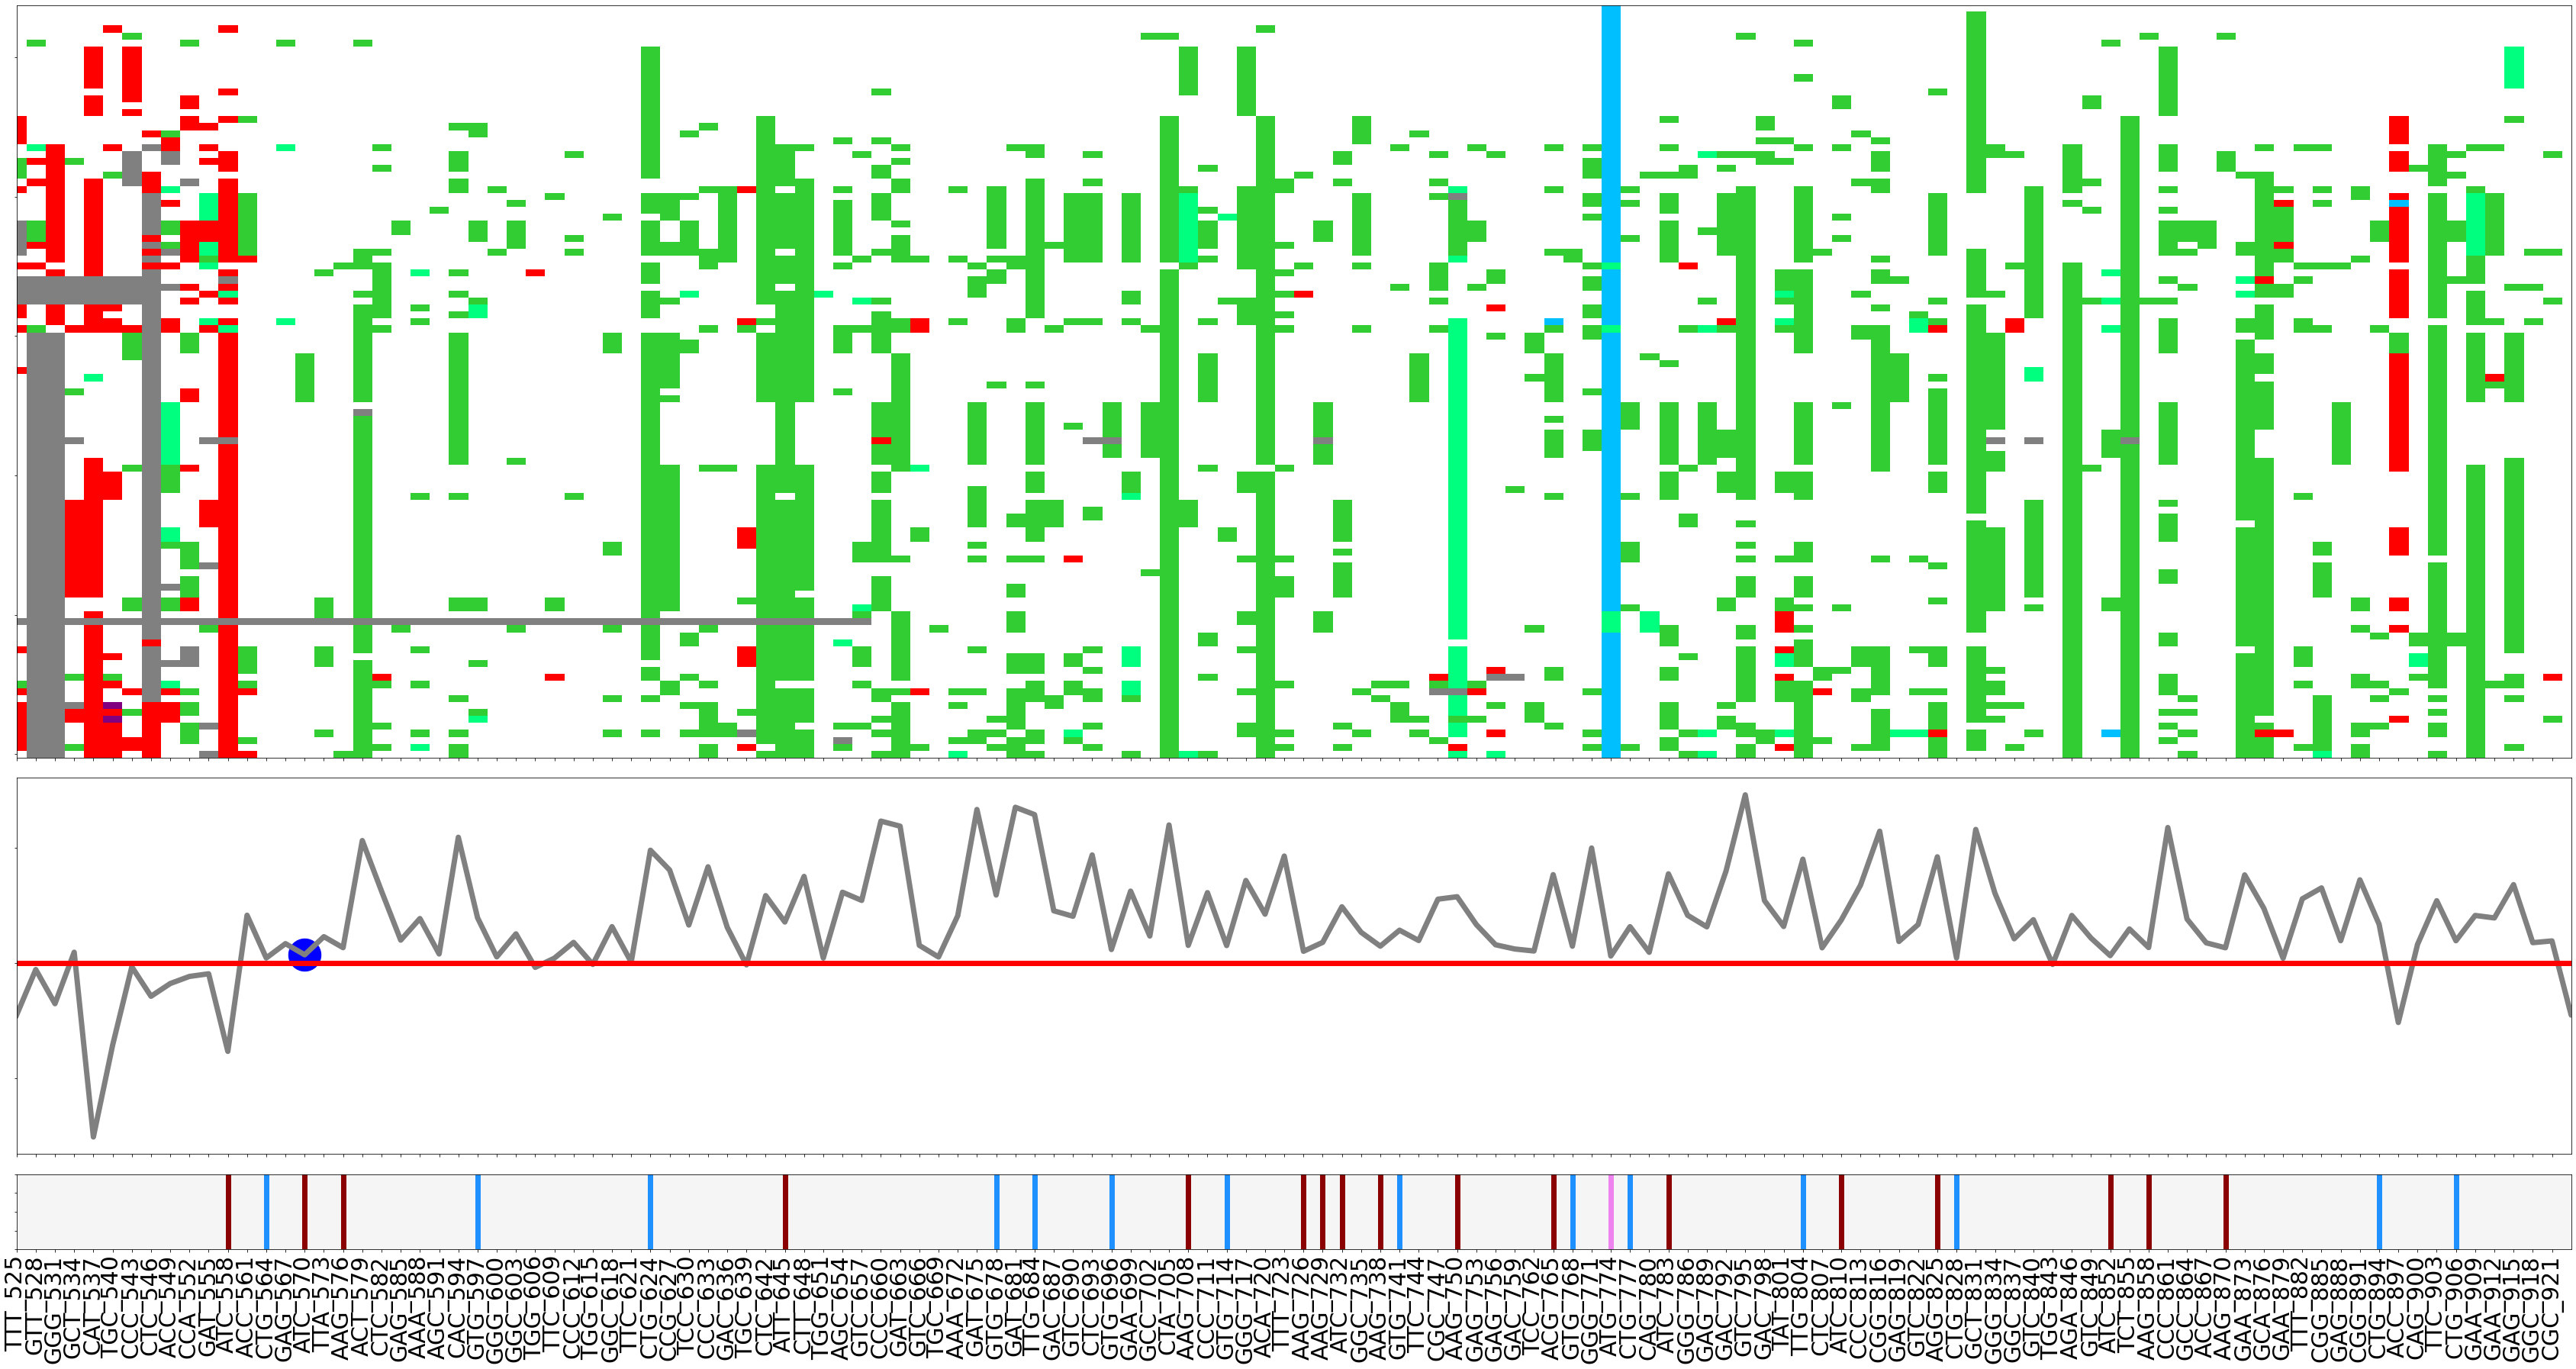

In [10]:
matrix = output_matrix_for_plotting(fasta_input='data/FASTA_aln_NTE_CDS_50codons/CCDC8_primary_and_50codons_CDS.fasta')

d =  prepare_data_for_PCSF_line_plot(tr_id='ENST00000307522.3', 
                                     primary_set=R_Set, 
                                     RES=RES, 
                                     res=res, 
                                     CDS=True)

plot_PCSF_score_and_aln_trips(d = d, 
                        matrix=matrix,
                figsize=(60, 30), 
                X=45, 
                Y=30, 
                add_point=15) # position of predicted by Trips-viz start in codons 

# mRNA secondary structure (RNAfold dG)

### Predicted nonAUG starts in RiboSET

In [11]:
li = []

fasta = open('tmp_res/Rset_preds_upstream_and_downstream_50nt.fasta', 'w')

tmp = R_Set[['tr_id', 'gene', 'N_term_start1', 'N_term_end1', 'Riboseq_Summary']]

tmp['start_init'] = [int(x.split(';')[1].split('-')[0]) for x in R_Set['Riboseq_Summary'].tolist()]

tmp['start_codon'] = [x.split(';')[0] for x in R_Set['Riboseq_Summary'].tolist()]

for el in tmp.to_numpy():
    tr_id = el[0]
    gene = el[1]
    N_term_start = el[2]
    N_term_end = el[3]
    start_pos = el[-2]
    start_codon = el[-1]
    
    trseq = metadata_pc_g25[metadata_pc_g25['tr_id'] == tr_id].iloc[0].transcript_seq
    
    
    # within the range of -50; nonAUG; +50nt
    # make 22nt long sequences with 1nt shift
    
    if start_pos - 1 >= 12:
        surr_100nt = trseq[start_pos-1-12:start_pos-1+103+21]
    else: 
        surr_100nt = trseq[0:start_pos-1+103+21] 
        
    # iterate over it 
    if start_pos - 1 >= 12:
        for i in range(0, len(surr_100nt)-21, 1):
            subset_22 = surr_100nt[i:i+22]
            fasta.write('>'+tr_id+'_'+gene+'_'+str(i)+'\n')       
            fasta.write(subset_22+'\n')
    else:
        for i in range(0, len(surr_100nt)-21, 1):
            k =  12 - start_pos + 1 + i
            subset_22 = surr_100nt[i:i+22]
            fasta.write('>'+tr_id+'_'+gene+'_'+str(k)+'\n')       
            fasta.write(subset_22+'\n')
        
    if tr_id == 'ENST00000379389.4':
        print (surr_100nt[-22:])
 
fasta.close()

/home/alla/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/alla/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


GTGTCCCTGAGCAGCTCCATGT


RNAfold < ../tmp_res/Rset_preds_upstream_and_downstream_50nt.fasta > RNAfold/Rset_preds_upstream_and_downstream_50nt_deltaG_RNAFOLD.out

In [12]:
li = []
for seq_record in SeqIO.parse("data/RNAfold/Rset_preds_upstream_and_downstream_50nt_deltaG_RNAFOLD.out", "fasta"):
    ids = seq_record.id
    record_seq = str(seq_record.seq)
    dG = record_seq.split('(')[-1].replace(')', '') 
    
    num = ids.split('_')[-1]
    gene = ids.split('_')[1]
    tr_id = ids.split('_')[0]
    
    li.append([gene, tr_id, num, dG])
    
out = pd.DataFrame(li, columns = ['gene', 'tr_id', 'num', 'dG']).reset_index()

out['num'] = out['num'].astype(int)

out['dG'] = out['dG'].astype(float)

out[0:2]

,index,gene,tr_id,num,dG
0,0,ISG15,ENST00000379389.4,0,-7.1
1,1,ISG15,ENST00000379389.4,1,-2.9


In [13]:
pivot = out.pivot(index=['gene', 'tr_id'], columns='num', values='dG')

li = []
for i, col in enumerate(pivot.to_numpy().T): 
    mean = np.nanmean(col)
    li.append([i, mean])
    
mean_dG = pd.DataFrame(li, columns = ['i', 'mean'])

# re-lable: -12:-1 0 1 2 ... 82 
mean_dG['relative position to START'] = list(range(-10, 1)) + list(range(1, 105))

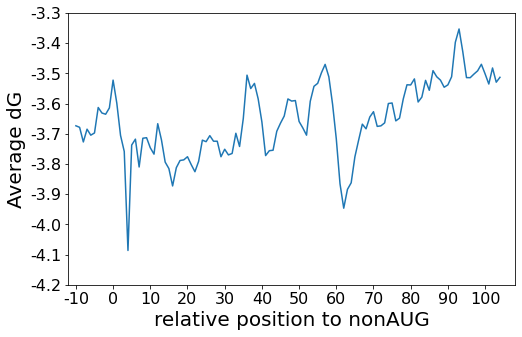

In [14]:
ax, fix = plt.subplots(figsize=(8,5))
ax = sns.lineplot(data=mean_dG, 
                  x='relative position to START', 
                  y="mean")

ax.set_xlim(-12, 108)
ax.set_xticks([-10,  0]+list(range(10, 108, 10)))
ax.set_xticklabels([-10,  0]+list(range(10, 108, 10)), fontsize=16)

ax.set_yticks(np.arange(-4.2, -3.2, 0.1))
ax.set_yticklabels([np.round(x, 1) for x in np.arange(-4.2, -3.2, 0.1)], fontsize=16)

ax.set_ylabel('Average dG', fontsize=20)
ax.set_xlabel('relative position to nonAUG', fontsize=20)

plt.show()

# 400 genes with AUGs in a weak context

In [ ]:
li = []

for el in metadata_pc_g25[['tr_id', 'gene', 'transcript_seq', 'cds_start_pos', 'cds_stop_pos']].to_numpy():
    cds_start = el[-2]
    cds_stop = el[-1]
    tr_id = el[0]
    gene = el[1]
    trseq = el[2]
    
    # extract context and score it 
    if cds_start >= 6:
        try:
            TIS_cds = trseq[cds_start-6:cds_start+5].replace('T', 'U')
            TIS_score = TIS_AUG_eff[TIS_AUG_eff['sequence'] == TIS_cds].iloc[0].efficiency
            li.append([tr_id, gene, TIS_cds, TIS_score])
        except Exception as e:
            print (e, tr_id, gene)
        
AUG_cds_TIS_score_df = pd.DataFrame(li, columns = ['tr_id', 'gene', 
                                                   'TIS_cds', 'TIS_score'])

single positional indexer is out-of-bounds ENST00000616713.4 SCNN1D
single positional indexer is out-of-bounds ENST00000624297.1 PRAMEF18
single positional indexer is out-of-bounds ENST00000622840.1 C1orf234
single positional indexer is out-of-bounds ENST00000373471.7 FNDC5
single positional indexer is out-of-bounds ENST00000610401.4 SSBP3
single positional indexer is out-of-bounds ENST00000545203.2 ROR1
single positional indexer is out-of-bounds ENST00000621530.1 ST6GALNAC3
single positional indexer is out-of-bounds ENST00000469039.2 AMPD2
single positional indexer is out-of-bounds ENST00000474459.5 AMPD2


In [ ]:
print (metadata_pc_g25.merge(AUG_cds_TIS_score_df, on=['tr_id', 'gene'], how='inner').sort_values(by='TIS_score')[0:794].gene.nunique())

bottom400genes = metadata_pc_g25.merge(AUG_cds_TIS_score_df, on=['tr_id', 'gene'], how='inner').sort_values(by='TIS_score')[0:794]

bottom400genes_1tr_per_gene = bottom400genes.groupby('gene').sample(n=1) 

In [ ]:
# BOTTOM TIS score!!!! 

fasta = open('tmp_res/cdsAUG_400genes_400tr_bottomTISscore.fasta', 'w')

for el in bottom400genes_1tr_per_gene[['tr_id', 'gene', 'transcript_seq', 'cds_start_pos', 'cds_stop_pos']].to_numpy():
    start_pos = el[-2]
    cds_stop = el[-1]
    tr_id = el[0]
    gene = el[1]
    trseq = el[2]
    
    # get 12nt_AUG_100nt sequence 
    if start_pos - 1 >= 12:
        surr_100nt = trseq[start_pos-1-12:start_pos-1+103+21]
    else: 
        surr_100nt = trseq[0:start_pos-1+103+21] 
        
    # iterate over it 
    if start_pos - 1 >= 12:
        for i in range(0, len(surr_100nt)-21, 1):
            subset_22 = surr_100nt[i:i+22]
            fasta.write('>'+tr_id+'_'+gene+'_'+str(i)+'\n')       
            fasta.write(subset_22+'\n')
    else:
        for i in range(0, len(surr_100nt)-21, 1):
            k =  12 - start_pos + 1 + i
            subset_22 = surr_100nt[i:i+22]
            fasta.write('>'+tr_id+'_'+gene+'_'+str(k)+'\n')       
            fasta.write(subset_22+'\n')
    
fasta.close()

cd data/RNAfold

RNAfold < ../../tmp_res/cdsAUG_400genes_400tr_bottomTISscore.fasta > cdsAUG_400genes_400tr_bottomTISscore.out

In [ ]:
li = []
for seq_record in SeqIO.parse("data/RNAfold/cdsAUG_400genes_400tr_bottomTISscore.out", "fasta"):
    ids = seq_record.id
    record_seq = str(seq_record.seq)
    dG = record_seq.split('(')[-1].replace(')', '') 
    
    num = ids.split('_')[-1]
    gene = ids.split('_')[-2]
    tr_id = ids.split('_')[0]
    #num_codon_in_tr = ids.split('_')[-3]
    
    li.append([gene, tr_id, num, dG])
    
out = pd.DataFrame(li, columns = ['gene', 'tr_id', 'num', 'dG'])#.reset_index()

out['num'] = out['num'].astype(int)

out['dG'] = out['dG'].astype(float)

In [ ]:
pivot = out.pivot_table(index=['gene', 'tr_id'], 
                  columns='num', values='dG')

li = []
for i, col in enumerate(pivot.to_numpy().T):
    
    mean = np.nanmean(col)
    
    li.append([i, mean])
    
mean_dG2 = pd.DataFrame(li, columns = ['i', 'mean'])

# re-lable: -12:-1 0 1 2 ... 82 
mean_dG2['relative position to START'] = list(range(-10, 1)) + list(range(1, 105))

In [ ]:
out

In [ ]:
mean_dG2

# 400 genes with AUGs in a strong context

In [ ]:
print (metadata_pc_g25.merge(AUG_cds_TIS_score_df, on=['tr_id', 'gene'], how='inner').sort_values(by='TIS_score')[-1168:].gene.nunique())

top400genes = metadata_pc_g25.merge(AUG_cds_TIS_score_df, on=['tr_id', 'gene'], how='inner').sort_values(by='TIS_score')[-1168:]

top400genes_1tr_per_gene = top400genes.groupby('gene').sample(n=1) 

top400genes_1tr_per_gene[0:2]

fasta = open('tmp_res/TIS_topTISscore_cdsAUG.fasta', 'w')

for el in top400genes_1tr_per_gene[['tr_id', 'TIS_cds']].to_numpy():
    fasta.write('>'+el[0]+'\n')
    fasta.write(el[1][2:-1]+'\n')
    
fasta.close()

In [ ]:
fasta = open('tmp_res/cdsAUG_300genes_real_top_TISscore.fasta', 'w')

for el in top400genes_1tr_per_gene[['tr_id', 'gene', 'transcript_seq', 'cds_start_pos', 'cds_stop_pos']].to_numpy():
    start_pos = el[-2]
    cds_stop = el[-1]
    tr_id = el[0]
    gene = el[1]
    trseq = el[2]
    
    # get 12nt_AUG_100nt sequence 
    if start_pos - 1 >= 12:
        surr_100nt = trseq[start_pos-1-12:start_pos-1+103+21]
    else: 
        surr_100nt = trseq[0:start_pos-1+103+21] 
        
    # iterate over it 
    if start_pos - 1 >= 12:
        for i in range(0, len(surr_100nt)-21, 1):
            subset_22 = surr_100nt[i:i+22]
            fasta.write('>'+tr_id+'_'+gene+'_'+str(i)+'\n')       
            fasta.write(subset_22+'\n')
    else:
        for i in range(0, len(surr_100nt)-21, 1):
            k =  12 - start_pos + 1 + i
            subset_22 = surr_100nt[i:i+22]
            fasta.write('>'+tr_id+'_'+gene+'_'+str(k)+'\n')       
            fasta.write(subset_22+'\n')
    
fasta.close()

cd data/RNAfold

RNAfold < ../../tmp_res/cdsAUG_300genes_real_top_TISscore.fasta > cdsAUG_300genes_real_top_TISscore.out

In [ ]:
li = []
for seq_record in SeqIO.parse("data/RNAfold/cdsAUG_300genes_real_top_TISscore.out", "fasta"):
    ids = seq_record.id
    record_seq = str(seq_record.seq)
    dG = record_seq.split('(')[-1].replace(')', '') 
    
    num = ids.split('_')[-1]
    gene = ids.split('_')[-2]
    tr_id = ids.split('_')[0]
    
    li.append([gene, tr_id, num, dG])
    
out = pd.DataFrame(li, columns = ['gene', 'tr_id', 'num', 'dG'])#.reset_index()

out['num'] = out['num'].astype(int)

out['dG'] = out['dG'].astype(float)

In [ ]:
pivot = out.pivot_table(index=['gene', 'tr_id'], 
                  columns='num', values='dG')

li = []
for i, col in enumerate(pivot.to_numpy().T):
    
    mean = np.nanmean(col)
    
    li.append([i, mean])
    
mean_dG3 = pd.DataFrame(li, columns = ['i', 'mean'])

# re-lable: -12:-1 0 1 2 ... 82 
mean_dG3['relative position to START'] = list(range(-10, 1)) + list(range(1, 105))

# Combine control (AUGs) with nonAUGs

In [ ]:
mean_dG2['type'] = 'high TIS-scored AUG'
mean_dG['type'] = 'predicted nonAUG'
mean_dG3['type'] = 'low TIS-scored AUG'

mean_df = pd.concat([mean_dG2, mean_dG3, mean_dG])


mean_df

In [ ]:
ax, fig = plt.subplots(figsize=(6.4,4.8))
ax = sns.lineplot(data=mean_df, 
                  x='relative position to START', 
                  y="mean",
                  hue = 'type')

ax.set_xlim(-12, 108)
ax.set_xticks([-10,  0]+list(range(10, 108, 20)))
ax.set_xticklabels([-10,  0]+list(range(10, 108, 20)), fontsize=16)

ax.set_yticks(np.arange(-4.2, -0.5, 0.5))
ax.set_yticklabels([np.round(x, 1) for x in np.arange(-4.2, -0.5, 0.5)], fontsize=16)

ax.set_ylabel('Average dG', fontsize=20)
ax.set_xlabel('relative position to start codon', fontsize=20)



plt.savefig('plots/mRNA_secondary_structure', format='svg', dpi=1200, bbox_inches="tight")

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:])

# ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=12)
ax.legend(loc='upper right', fontsize=13)

plt.show()

# Distribution of start codon types 

In [ ]:
R_Set['codon_type'] = [x.split(';')[0] for x in R_Set['Riboseq_Summary'].tolist()]

R_Set['codon_position'] = [int(x.split('; ')[1].split('-')[0]) for x in R_Set['Riboseq_Summary'].tolist()]

barplot = R_Set[['codon_type', 'codon_position']].groupby('codon_type').count().reset_index().sort_values(by='codon_position')

barplot.columns = ['codon', 'counts']

barplot['codon'] = [x.replace('T', 'U') for x in barplot['codon'].tolist()]

barplot[barplot['codon'] != 'ATG']

In [ ]:
ax, fig = plt.subplots(figsize=(4.5, 3))

# sns.despine(left = True, bottom = True)

ax = sns.barplot(y="codon", x="counts", 
                 data=barplot[barplot['codon'] != 'ATG'])

ax.set_yticklabels(barplot[barplot['codon'] != 'ATG'].codon.tolist(), fontsize=14)

ax.set_xticks(list(range(0, 170, 20)))
ax.set_xticklabels(list(range(0, 170, 20)), fontsize=14)

ax.set_ylabel('codon type', fontsize = 18)

ax.set_xlabel('number of extensions\n in RiboSET', fontsize = 18)

plt.show()

In [ ]:
R_Set[R_Set['codon_type'] == 'ATG']

# AAG-initiator example 

In [ ]:
R_Set[R_Set['tr_id'] == 'ENST00000368811.7']

In [ ]:
gene = 'S100A10'

tr_id = 'ENST00000368811' # ENST00000262942.9


pred_start = R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split(';')[0]
pos_pred_start = R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0] 


pre_st = pos_pred_start + '_' + pred_start

xlims = [R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*3]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_RiboSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =400, 
                             fraq = 20, 
                             cds = False,
                           figsize=(40, 20),
                           xlims=xlims,
                            zeros=False)

trips_full2(d1)

# TIS scores 

In [ ]:
# only in-frame starts 

def get_TIS(CODONli, ntermstart, trseq):
    '''
    extract 
    '''
    TIS_d = {}
    
    if len(CODONli) != 0:
        for codon_pos in CODONli:
            tr_pos = ntermstart + 3*codon_pos 
            TIS = trseq[tr_pos-4:tr_pos+4].replace('T', 'U')
            TIS_d[tr_pos] = TIS
            
    return TIS_d

In [ ]:
li = []

for i, el in enumerate(meta[['tr_id', 'N_term_start1', 'N_term_end1']].merge(metadata_pc_g25[['tr_id', 'transcript_seq', 'gene']]).to_numpy()):
    
    if i % 1000 == 0:
        print (i)
    tr_id = el[0]
    ntermstart = el[1]
    nternend = el[2]
    type_ = 'ALL'
    trseq = el[3]
    
    if (tr_id in R_Set.tr_id.tolist()):
        flag = 'RiboSET'
    elif tr_id in P_Set.tr_id.tolist():
        flag = 'PhyloSET'
    else:
        flag = 'general'

    
    
    # sequence of theoretical NTE 
    primary_seq = trseq[ntermstart:nternend]
    gene =  el[-1]
    
    
    # split sequence of primary extension into triplets 
    primary_seq = [primary_seq[i:i+3] for i in range(0, len(primary_seq), 3)]

    # find all ner-cognate codons and their context, and their start positions: should be between nstart and nend
    CTG = np.where(np.array(primary_seq) == 'CTG')[0]
    ATG = np.where(np.array(primary_seq) == 'ATG')[0]
    GTG = np.where(np.array(primary_seq) == 'GTG')[0] 
    TTG = np.where(np.array(primary_seq) == 'TTG')[0]
    ATA = np.where(np.array(primary_seq) == 'ATA')[0] 
    ATT = np.where(np.array(primary_seq) == 'ATT')[0] 
    ACG = np.where(np.array(primary_seq) == 'ACG')[0] 
    ATC = np.where(np.array(primary_seq) == 'ATC')[0] 
    AAG = np.where(np.array(primary_seq) == 'AAG')[0]  
    AGG = np.where(np.array(primary_seq) == 'AGG')[0] 
    
    for CODONli in [ATG, CTG, GTG, TTG, ATA, ATT, ACG, ATC, AAG, AGG]:
        TIS_d = get_TIS(CODONli, ntermstart, trseq)
        for tr_pos, TIS in TIS_d.items():
            codon = trseq[tr_pos:tr_pos+3]
            if TIS_d[tr_pos] is not '': # e.g. ENST00000400907.6 AAG 2
                #print (tr_id, codon, tr_pos, TIS_d[tr_pos])
                
                # we also need to add context of cdsAUG for each transcript 
                cdsAUG_TIS = trseq[nternend-4:nternend+4].replace('T', 'U')
                cdsAUG_TIS_ext = trseq[nternend-6:nternend+5].replace('T', 'U')
                
                try:
                    codon_type = R_Set[R_Set['tr_id'] == tr_id].iloc[0].codon_type
                    codon_position = R_Set[R_Set['tr_id'] == tr_id].iloc[0].codon_position
                    if (tr_id in R_Set.tr_id.tolist()) & (tr_pos == codon_position-1) & (codon == codon_type):
                        flag2 = 'RiboSET_pred'
                    elif (tr_id in R_Set.tr_id.tolist()):
                        flag2 = 'RiboSET_remaining'
                    else:
                        flag2 = None
                    
                except:
                    codon_type = None
                    codon_position = None
                    flag2 = None
                
                
                
                
                #print (cdsAUG_TIS_ext)
                
                
                # get score for TIS. some in-frame upstream AUG might happen
                if TIS_d[tr_pos] in TIS_efficiency_dict:
                    TISscore = TIS_efficiency_dict[TIS_d[tr_pos]]                
                    TISscore_scaled = TIS_efficiency_dict_scaled[TIS_d[tr_pos]]
                else:
                    TISscore = None
                    TISscore_scaled = None
                
                if cdsAUG_TIS_ext in TIS_AUG_eff_dict:
                    TISscore_AUG = TIS_AUG_eff_dict[cdsAUG_TIS_ext]
                    TISscore_AUG_scaled = TIS_AUG_eff_dict_scaled[cdsAUG_TIS_ext]
                    
                    #print (TISscore_AUG_scaled)
                else:
                    TISscore_AUG = None
                    TISscore_AUG_scaled = None
                    
                
                li.append([tr_id, codon, tr_pos, TIS_d[tr_pos], 
                           cdsAUG_TIS, TISscore, gene, cdsAUG_TIS_ext, 
                           TISscore_AUG, TISscore_scaled,  TISscore_AUG_scaled, 
                           type_, flag, flag2])
            
            # there might be a situation when there is no 4nt before start => discard such cases 
        
        
    
TISdf = pd.DataFrame(li, columns = ['tr_id', 'codon', 'pos_of_codon', 'TIS', 'cdsAUG_TIS', 
                                    'TIS_score', 'gene', 'cdsAUG_TIS_ext', 'TISscore_AUG', 
                                    'TISscore_scaled', 'TISscore_AUG_scaled', 'type', 'flag', 'flag2'])

print (TISdf.shape)

TISdf[0:2]

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7,4))

#ax = sns.distplot(TISdf[TISdf['flag'] == 'general'].TIS_score.tolist(), 
#                  hist=False, 
#                  label = 'All non-AUG in theoretical NTE')


ax = sns.distplot(TISdf[TISdf['flag'] == 'RiboSET'].TIS_score.tolist(), 
                  hist=False, 
                  label = 'All non-AUG in theoretical NTE\n RiboSET',
                 kde_kws = {'shade': True, 'linewidth': 3},
                 color = 'gold')


ax = sns.distplot(TISdf[TISdf['flag'] == 'PhyloSET'].TIS_score.tolist(), 
                  hist=False, 
                  label = 'All non-AUG in theoretical NTE\n PhyloSET',
                 kde_kws = {'shade': True, 'linewidth': 3},
                 color = 'forestgreen')


ax = sns.distplot(TISdf[TISdf['flag2'] == 'RiboSET_pred'].TIS_score.tolist(), 
                  hist=False, 
                  label = 'Trips-viz predicted non-AUG\n RiboSET',
                 kde_kws = {'shade': True, 'linewidth': 3},
                 color = 'blueviolet')


ax.set_xticks(range(0, 60, 10))
ax.set_xticklabels(list(range(0, 60, 10)), fontsize=17)

ax.set_yticks(np.arange(0, 0.5, 0.1))
ax.set_yticklabels([np.round(x, 1) for x in np.arange(0, 0.5, 0.1)], fontsize=17)

ax.set_xlabel('nonAUG TIS raw score', fontsize=17)

ax.set_title('TIS scores distribution', fontsize=19)

plt.legend(prop={'size': 16})

plt.show()

In [ ]:
a = TISdf[TISdf['flag2'] == 'RiboSET_pred'][['TIS_score']]
a['flag'] = 'RiboSET_Pred'

b = TISdf[TISdf['flag'] == 'PhyloSET'][['TIS_score']]
b['flag'] = 'PhyloSET'

c = TISdf[TISdf['flag'] == 'RiboSET'][['TIS_score']]
c['flag'] = 'RiboSET'

abc = pd.concat([a,b,c])

plt.figure(figsize=(16,10), dpi= 80)
fig, axes = joypy.joyplot(abc, 
                          column=['TIS_score'], 
                          by="flag", 
                          ylim='own', 
                          figsize=(14,10),
                         overlap=5,
                         color=['gold', 'forestgreen', 'blueviolet'],
                         alpha=0.6)


axes[0].axvline(np.mean(b['TIS_score']), color='darkgoldenrod', linestyle='--')
axes[1].axvline(np.mean(c['TIS_score']), color='darkgreen', linestyle='--')
axes[2].axvline(np.mean(a['TIS_score']), color='purple', linestyle='--')

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7,3))

colors_list = ['#78C850', '#F08030',  '#6890F0',  '#A8B820',  '#F8D030', '#E0C068', '#C03028', '#F85888', '#98D8D8']

ax = sns.violinplot(y='flag', x='TIS_score', 
               data=abc, 
               scale='width', 
              palette=['blueviolet', 'gold', 'forestgreen'])

ax.axvline(np.mean(b['TIS_score']), color='darkgoldenrod', linestyle='--')
ax.axvline(np.mean(c['TIS_score']), color='darkgreen', linestyle='--')
ax.axvline(np.mean(a['TIS_score']), color='purple', linestyle='--') #ribo-set pred

ax.set_yticklabels(['RiboSET_pred', 'PhyloSET', 'RiboSET'], fontsize=15)
ax.set_xticklabels(list(range(0, 80, 10)), fontsize=15)

ax.set_ylabel('set', fontsize=18)
ax.set_xlabel('TIS_score', fontsize=18)

plt.show()

### save TIS score df 

In [ ]:
TISdf[(TISdf['flag2'] == 'RiboSET_pred') & (TISdf['codon'] != 'ATG')].to_csv('Supplementary_tables_and_plots/tables/TIS_RiboSET_nonAUG.txt', sep='\t', index=False)

# Kolmogorov-smirnov test 

In [ ]:
from scipy.stats import ks_2samp
import numpy as np 

ks_2samp(TISdf[TISdf['flag2'] == 'RiboSET_pred'].TIS_score.tolist(),
        TISdf[TISdf['flag'] == 'RiboSET'].TIS_score.tolist())

# Sequence Logo context 

In [ ]:
fasta = open('tmp_res/TIS_Riboseq_pred.fasta', 'w')

for el in TISdf[TISdf['flag2'] == 'RiboSET_pred'][['tr_id', 'codon', 'pos_of_codon', 'TIS']].to_numpy():
    fasta.write('>'+el[0]+'_'+el[1]+'_'+str(el[2])+'\n')
    fasta.write(el[3].replace('T', 'U')+'\n')
    
    
fasta.close()

In [ ]:
fasta = open('tmp_res/TIS_Riboseq_pred-CTG.fasta', 'w')

for el in TISdf[(TISdf['codon'] == 'CTG') & (TISdf['flag2'] == 'RiboSET_pred')][['tr_id', 'codon', 'pos_of_codon', 'TIS']].to_numpy():
    fasta.write('>'+el[0]+'_'+el[1]+'_'+str(el[2])+'\n')
    fasta.write(el[3].replace('T', 'U')+'\n')
    
    
fasta.close()

In [ ]:
fasta = open('tmp_res/TIS_Riboseq_pred-ATC.fasta', 'w')

for el in TISdf[(TISdf['flag2'] == 'RiboSET_pred') & (TISdf['codon'] == 'ATC')][['tr_id', 'codon', 'pos_of_codon', 'TIS']].to_numpy():
    fasta.write('>'+el[0]+'_'+el[1]+'_'+str(el[2])+'\n')
    fasta.write(el[3].replace('T', 'U')+'\n')
    
    
fasta.close()

In [ ]:
import matplotlib
print (matplotlib.__version__)

print (pd.__version__)

# Comparison with NAR paper (TCP-seq+TCP-sel-seq+RiboSET+Proteomics)

### List of identified ORFs and TISs by TISCA

In [ ]:
tisca = pd.read_csv('data/TIS_ORF_TISCA.csv')

print (tisca[(tisca['orftype'] == 'extension') & (tisca['TIS start codon'] != 'ATG')].gene_name.nunique(), tisca[(tisca['orftype'] == 'extension') & (tisca['TIS start codon'] != 'ATG')].gene_name.shape)


print (tisca[(tisca['orftype'] == 'extension') & (tisca['TIS start codon'] == 'ATG')].gene_name.nunique(), tisca[(tisca['orftype'] == 'extension') & (tisca['TIS start codon'] == 'ATG')].gene_name.shape)

tisca_ext_df = tisca[tisca['orftype'] == 'extension'][['ORF_ID', 'gene_name', 'tid', 'TIS start codon', 'orftype', 'tcoord']]

tisca_ext_df.columns = ['ORF_ID', 'gene', 'tr_id', 'codon_type', 'orf_type', 'codon_position']

tisca_ext_df['codon_position'] = tisca_ext_df['codon_position']+1

tisca_ext_df['tr_id1'] = [x.split('.')[0] for x in tisca_ext_df['tr_id'].tolist()]

tisca_ext_df[0:2]

In [ ]:
R_Set['tr_id1'] = [x.split('.')[0] for x in R_Set['tr_id'].tolist()]

P_Set['tr_id1'] = [x.split('.')[0] for x in P_Set['tr_id'].tolist()]

In [ ]:
R_Set.merge(tisca_ext_df, on=['tr_id1', 'gene', 'codon_type', 'codon_position']).gene.nunique()

In [ ]:
R_Set.merge(tisca_ext_df, on=['tr_id1', 'gene']).gene.nunique(), R_Set.merge(tisca_ext_df, on=['tr_id1', 'gene']).tr_id1.nunique()

In [ ]:
P_Set.merge(tisca_ext_df, on=['tr_id1', 'gene']).gene.nunique(), P_Set.merge(tisca_ext_df, on=['tr_id1', 'gene']).tr_id1.nunique()

### proteomics data

In [ ]:
tisca_prot = pd.read_csv('data/TISCA_proteomics.csv')

In [ ]:
tmp = tisca_prot[tisca_prot['TISCA'] == True][['Proteins', 'Proteins_N']]

evidence_proteomics_and_tisca = []

proteins_df = tmp.set_index('Proteins')['Proteins_N'].str.split(';', expand=True).stack().reset_index(name='Proteins_N').drop('level_1',1)

for el in proteins_df['Proteins_N'].tolist():
    if el.find('ENST') != -1:    
        orf_id = el.split('_')[0]+'_'+el.split('_')[1]+'_'+el.split('_')[2]
        evidence_proteomics_and_tisca.append(orf_id)
        
evidence_proteomics_and_tisca_li = list(set(evidence_proteomics_and_tisca))

print (len(evidence_proteomics_and_tisca_li))